In [1]:
import cv2 as cv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

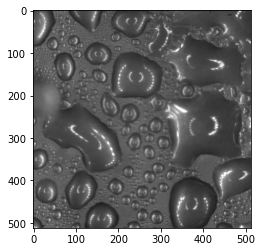

In [2]:
im_in_actual = cv.imread("C:\\Users\\grdmg\\Desktop\\image_0.tif")
plt.imshow(im_in_actual)
plt.show()

In [3]:
def unsharp_mask(image, kernel_size=(9, 9), sigma=2.0, amount=2.0, threshold=0):
    blurred = cv.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [4]:
def CC(img):
    nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(img)
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    return labeled_img, nlabels, labels, stats, centroids

In [5]:
def MakeWhite(image, alpha, beta): #alpha:1-3, beta:0 -100
    new_image = np.zeros(image.shape, im_in_actual.dtype)
    #alpha = 2.5  # Simple contrast control
    #beta = 10  # Simple brightness control
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y, x, c] = np.clip(alpha * image[y, x, c] + beta, 0, 255)
    new_image = cv.medianBlur(new_image, 3)
    new_image = cv.medianBlur(new_image, 5)
    new_image = cv.medianBlur(new_image, 3)
    return new_image

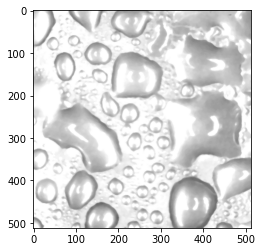

In [6]:
im_light = MakeWhite(im_in_actual, 2.5, 20) #alpha:1-3, beta:0 -100
plt.imshow(im_light)
plt.show()

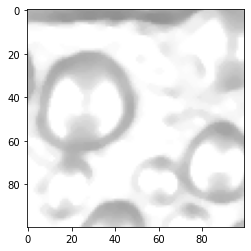

In [7]:
crop = im_light[200:300, 200:300]
plt.imshow(crop)
plt.show()

In [8]:
print("this is how the brake down will happen")
"""
counter = 1
for i in range(0, 500, 100):
    for j in range(0, 500, 100):
        k = i + 100
        m = j + 100
        crop = im_light[i:k, j:m]
        print(f'the crop is [{i}:{k}, {j}:{m}], and the counter is {counter}')
        counter = counter + 1
        plt.imshow(crop)
        plt.show()
"""

this is how the brake down will happen


"\ncounter = 1\nfor i in range(0, 500, 100):\n    for j in range(0, 500, 100):\n        k = i + 100\n        m = j + 100\n        crop = im_light[i:k, j:m]\n        print(f'the crop is [{i}:{k}, {j}:{m}], and the counter is {counter}')\n        counter = counter + 1\n        plt.imshow(crop)\n        plt.show()\n"

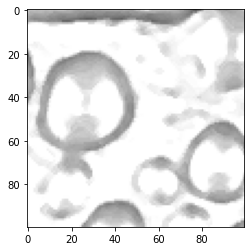

In [9]:
crop_sharp = unsharp_mask(crop, kernel_size=(9, 9), sigma=2.0, amount=2.0, threshold=0)
plt.imshow(crop_sharp)
plt.show()

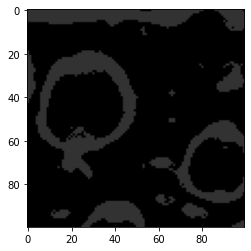

In [10]:
th, crop_sharp_th = cv.threshold(crop_sharp, 200, 50, cv.THRESH_BINARY_INV);
plt.imshow(crop_sharp_th)
plt.show()

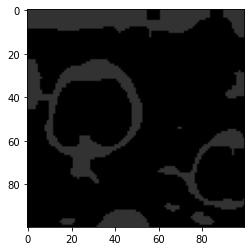

In [11]:
kernel = np.ones((2, 2), np.uint8)
dilation = cv.dilate(crop_sharp_th, kernel, iterations=3)
erosion = cv.erode(dilation , kernel, iterations=4)
plt.imshow(erosion )
plt.show()

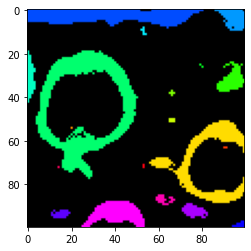

[[   0    0  100  100 7597]
 [   0    0   81    9  483]
 [  86    0   14   10   95]
 [  52    8    3    4    6]
 [   0   19    4   24   64]
 [   4   19   47   59  871]
 [  79   25    2    2    2]
 [  87   24   13   14  102]
 [  65   37    3    3    5]
 [  65   50    3    2    6]
 [  56   51   44   38  430]
 [  20   54    1    1    1]
 [  90   63    2    1    2]
 [  53   71    1    2    2]
 [  14   72    1    1    1]
 [  59   85    9    5   24]
 [  25   88   29   12  216]
 [  71   89   12    7   54]
 [  11   92    9    4   27]
 [  94   97    6    3   12]]


In [12]:
erosion = cv.cvtColor(crop_sharp_th, cv.COLOR_BGR2GRAY)
components, nlabels, labels, stats, centroids = CC(erosion)
plt.imshow(components)
plt.show()
print(stats)

In [13]:
final_stats = []
final_centroids = []
f_stat_counter = 0
for i in range(stats.shape[0]):
    if (stats[i][4] > 1000) or (stats[i][2] < 10) or (stats[i][3] < 10):
        pass
    else:
        final_stats.append(stats[i])
        final_centroids.append(centroids[i])
FStats = np.array(final_stats, dtype=object)
FCentr = np.array(final_centroids, dtype= int)
print(FStats)
print(FCentr)

print(FCentr[0])

[[86 0 14 10 95]
 [4 19 47 59 871]
 [87 24 13 14 102]
 [56 51 44 38 430]
 [25 88 29 12 216]]
[[94  3]
 [26 44]
 [93 31]
 [82 69]
 [40 93]]
[94  3]


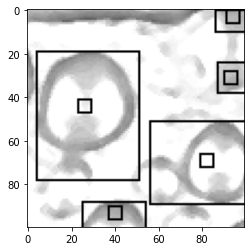

In [14]:
out = crop_sharp
for row in range(FCentr.shape[0]):
    X = FCentr[row][0]
    Y = FCentr[row][1]
    cv.rectangle(out, (X - 3, Y - 3), (X + 3, Y + 3), (0, 0, 0))
    cv.rectangle(out, (FStats[row][0], FStats[row][1]), (FStats[row][0] + FStats[row][2], FStats[row][1] + FStats[row][3]), (0, 0, 0))
plt.imshow(out)
plt.show()

In [19]:
print(crop.shape)
h, w = crop.shape[:2]
white = np.zeros([h , w , 3], dtype=np.uint8)
white.fill(255)
for i in range(1, h, 1):
    for j in range(1, w, 1):
        for row in range(FStats.shape[0]):
            x_crop = FStats[row][0]
            y_crop = FStats[row][1]
            v_crop = FStats[row][0] + FStats[row][2]
            h_crop = FStats[row][1] + FStats[row][3]
            white[i, j] = crop[x_crop:y_crop, v_crop:h_crop]
im_clean = white
plt.imshow(im_clean)
plt.show()
#im_clean = cv.cvtColor(im_clean, cv.COLOR_BGR2GRAY)


(100, 100, 3)


ValueError: could not broadcast input array from shape (0,0,3) into shape (3)